In [871]:
import sys
import affine
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
import rasterio
from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.features import shapes
from scipy.ndimage import gaussian_filter
from shapely.geometry import shape, Point, LineString
from shapely.ops import nearest_points
from affine import Affine
from shapely.geometry import box
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def RMSE(data):
    return np.sqrt((data ** 2).mean())


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def points_along_line(line_gdf, dist=10):    

    out = [] 
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(line_gdf.length), dist)):
        point = line_gdf.interpolate(distance)
        out.append(point[0])
        
    subpixel_points = gpd.GeoDataFrame(geometry=out, crs=line_gdf.crs)
    return subpixel_points


def dist_stats(ds, ref_gdf, subpixel_gdf, wholepixel_gdf, dist=10, clip_max=False):

    # Compute differences from points along sub-pixel waterline to reference waterline
    ref_union = ref_gdf.geometry.unary_union
    subpixel_points = points_along_line(subpixel_gdf, dist=dist)
    subpixel_points['dist_val'] = subpixel_points.apply(lambda x: x.geometry.distance(ref_union), axis=1)

    # Set directionality based on land or water line of reference line
    change_sign = np.where(ds.land_water.astype(float)
                           .interp(x=xr.DataArray(subpixel_points.geometry.x, dims='z'), 
                                   y=xr.DataArray(subpixel_points.geometry.y, dims='z')) >= 0.5, 1, -1)
    subpixel_points['dist_val'] = subpixel_points.dist_val * change_sign

    # Compute differences from points along whole-pixel waterline to reference waterline
    wholepixel_points = points_along_line(gpd.GeoSeries(wholepixel_gdf.unary_union), dist=dist)
    wholepixel_points['dist_val'] = wholepixel_points.apply(lambda x: x.geometry.distance(ref_union), axis=1)
    
    # If clip_max=True, remove all points located on the very edge of the study area.
    # This removes the outside of the polygonised study area from being included in the waterline
    if clip_max:
        wholepixel_points = wholepixel_points[(wholepixel_points.geometry.x != 
                                               wholepixel_points.geometry.x.max()) &
                                              (wholepixel_points.geometry.y != 
                                               wholepixel_points.geometry.y.min()) &
                                              (wholepixel_points.geometry.x != 
                                               wholepixel_points.geometry.x.min()) &
                                              (wholepixel_points.geometry.y != 
                                               wholepixel_points.geometry.y.max())].copy()

    # Set directionality based on land or water line of reference line
    change_sign = np.where(ds.land_water.astype(float)
                           .interp(x=xr.DataArray(wholepixel_points.geometry.x, dims='z'),
                                   y=xr.DataArray(wholepixel_points.geometry.y, dims='z')) >= 0.5, 1, -1)
    wholepixel_points['dist_val'] = wholepixel_points.dist_val * change_sign
    
    # Return dataframes of points and distances for sub-pixel and whole-pixel waterlines
    return subpixel_points, wholepixel_points


def simulated_waterlines(ds, agg_factor = 30, thresh_subpixel = 0, thresh_thresholded = 0, water_index='NDWI', min_vertices=2, outdir=''):
    
    # Aggregate data to new resolution and update transform
    ds_agg = ds.coarsen(x=agg_factor, y=agg_factor, boundary='trim').mean()
    ds_agg.attrs['transform'] = ds.transform * affine.Affine.scale(agg_factor)
    ds_agg.attrs['crs'] = ds.crs

    # Compute water index on aggregate data
    if water_index == 'NDWI':
        ds_agg['water_index'] = (ds_agg.green - ds_agg.nir) / (ds_agg.green + ds_agg.nir)
    if water_index == 'NDWI_wv2':
        ds_agg['water_index'] = (ds_agg.BAND_G - ds_agg.BAND_N) / (ds_agg.BAND_G + ds_agg.BAND_N)
    elif water_index == 'MNDWI':
        ds_agg['water_index'] = (ds_agg.green - ds_agg.swir1) / (ds_agg.green + ds_agg.swir1)
    elif water_index == 'AWEI_ns':
        ds_agg['water_index'] = ((4 * (ds_agg.green * 0.0001 - ds_agg.swir1 * 0.0001) - 
                                           (0.25 * ds_agg.nir * 0.0001 + 2.75 * ds_agg.swir2 * 0.0001)))
    elif water_index == 'AWEI_sh':
        ds_agg['water_index'] = (ds_agg.blue * 0.0001 + 2.5 * ds_agg.green * 0.0001 - 1.5 * 
                                          (ds_agg.nir * 0.0001 + ds_agg.swir1 * 0.0001) - 0.25 * ds_agg.swir2 * 0.0001)
        
    # Extract shoreline along true land-water validation boundary
    ref_gdf = SpatialTools.contour_extract(z_values=[0.5],
                                           ds_array=ds.land_water,
                                           ds_crs=ds.crs, 
                                           ds_affine=ds.transform, 
                                           output_shp=f'{outdir}reference.shp',
                                           min_vertices=min_vertices,
                                           verbose=False)

    # Extract subpixel shoreline along aggregated dataset based on water index
    subpixel_gdf = SpatialTools.contour_extract(z_values=[thresh_subpixel],
                                                ds_array=ds_agg.water_index,
                                                ds_crs=ds.crs,
                                                ds_affine=ds_agg.transform,
                                                output_shp=f'{outdir}subpixel_agg{agg_factor}.shp',
                                                min_vertices=min_vertices,
                                                verbose=False)

    # Threshold to water index value
    ds_bool = (ds_agg.water_index > thresh_thresholded)

    # Polygonise and filter to keep only values = 1
    geoms = list(shapes(ds_bool.values.astype(np.int16), transform=ds_agg.transform))
    geoms = [(a, b) for (a, b) in geoms if b == 1.0]
    geoms_shape = [shape(a) for (a, b) in geoms]
    data = [b for (a, b) in geoms]

    # Covert to a geodataframe of blocky waterlines
    wholepixel_gdf = gpd.GeoDataFrame(data={'value': data}, geometry = geoms_shape)
    wholepixel_gdf['geometry'] =  [LineString(i.coords) for i in wholepixel_gdf.geometry.exterior]
    wholepixel_gdf.crs = ds.crs
    wholepixel_gdf.to_file(f'{outdir}wholepixel_agg{agg_factor}.shp')
    
    # Return waterlines
    return ref_gdf, subpixel_gdf, wholepixel_gdf, ds_agg


def synthetic_spectra(thresh_array, spectra_scenarios, spectra):

        # Create 3D array with water and land spectra
        water_3d = np.broadcast_to(np.array(list(spectra_scenarios[spectra]['water'].values())), (size_x, size, 6)).T
        land_3d = np.broadcast_to(np.array(list(spectra_scenarios[spectra]['land'].values())), (size_x, size, 6)).T
        spectra_array = np.where(thresh_array, water_3d, land_3d)

        # Add validation land, water distribution as extra band
        spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

        # Convert to xarray format and rename bands
        synthetic_array = xr.DataArray(spectra_array, 
                                       dims=['variable', 'y', 'x'], 
                                       coords={'x': np.arange(0, 1000, 1), 
                                               'y': np.arange(0, -500, -1)})
        synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                          4: 'nir', 5: 'swir1', 6: 'swir2'})  

        # Set affine and CRS
        synthetic_ds.attrs['transform'] = affine.Affine(1, 0, 0, 0, 1, 0)
        synthetic_ds.attrs['crs'] = 'EPSG:4326' 
        
        return synthetic_ds


def synthetic_scenarios(thresh_array, scenarios_df, spectra_scenarios, dist=10):

    output_dist_list = []

    for i, (spectra, water_index, resolution, thresh_subpixel, thresh_thresholded) in scenarios_df.iterrows():

        print('\rSpectra:', spectra, 'Index:', water_index, 'Resolution:', resolution, 
              'Threshold subpixel:', np.round(thresh_subpixel, 2), 'Threshold threshholded:', np.round(thresh_thresholded, 2), end='')

        try:    

            ############################
            # Generate spectral xarray #
            ############################
            
            synthetic_ds = synthetic_spectra(thresh_array, spectra_scenarios, spectra)
    

            ####################
            # Model shorelines #
            ####################

            # Generate simulated shoreline based on input threshold and aggregation factor
            output_waterlines = simulated_waterlines(synthetic_ds, 
                                                     agg_factor = resolution, 
                                                     thresh_subpixel = thresh_subpixel, 
                                                     thresh_thresholded = thresh_thresholded, 
                                                     water_index = water_index)
            val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = output_waterlines

            # Compute OTSU on NDWI layer
            otsu = threshold_otsu(synthetic_coarse.water_index.values)

            # Compute distances
            subpixel_points, wholepixel_points = dist_stats(ds=synthetic_ds, 
                                                            ref_gdf=val_shoreline_gdf, 
                                                            subpixel_gdf=subpixel_shoreline_gdf, 
                                                            wholepixel_gdf=blocky_shoreline_gdf, 
                                                            dist=dist,
                                                            clip_max=True)   

            # Append to list
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_subpixel, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Sub-pixel', 
                                                  'Error (m)': subpixel_points['dist_val'], 'otsu': otsu}))
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_thresholded, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Whole-pixel', 
                                                  'Error (m)': wholepixel_points['dist_val'], 'otsu': otsu}))                                   

        except:
            pass

    # Combine results into a single dataframe
    accuracy_results = pd.concat(output_dist_list)
    
    # Return dataframe
    return accuracy_results


def wv2_scenarios(wv2_ds, scenarios_df, dist=10):

    output_dist_list = []

    for i, (spectra, water_index, resolution, thresh_subpixel, thresh_thresholded) in scenarios_df.iterrows():

        print('\rSpectra:', spectra, 'Index:', water_index, 'Aggregation:', resolution, 
              'Threshold subpixel:', np.round(thresh_subpixel, 2), 'Threshold threshholded:', np.round(thresh_thresholded, 2), end='')

        try:    
   

            ####################
            # Model shorelines #
            ####################

            # Generate simulated shoreline based on input threshold and aggregation factor
            output_waterlines = simulated_waterlines(wv2_ds, 
                                                     agg_factor = resolution, 
                                                     thresh_subpixel = thresh_subpixel, 
                                                     thresh_thresholded = thresh_thresholded, 
                                                     water_index=water_index,
                                                     outdir='output_data/wv2/wv2_')
            wv2_ref_gdf, wv2_subpixel_gdf, wv2_wholepixel_gdf, wv2_agg_ds = output_waterlines

            # Compute OTSU on NDWI layer
            selected_env = wv2_env_gdf[wv2_env_gdf.env_type == spectra].unary_union            
            mask = rasterio.features.rasterize([selected_env.__geo_interface__], 
                                               out_shape=(len(wv2_agg_ds.y), len(wv2_agg_ds.x)), 
                                               transform=wv2_agg_ds.transform, all_touched=True)            
            
            wv2_agg_array = wv2_agg_ds.where(mask).water_index.values
            otsu = threshold_otsu(wv2_agg_array[np.isfinite(wv2_agg_array)])
            
            # Clip to env extent
            wv2_subpixel_gdf = wv2_subpixel_gdf.intersection(selected_env)
            wv2_wholepixel_gdf = wv2_wholepixel_gdf.intersection(selected_env)
            wv2_ref_gdf = wv2_ref_gdf.intersection(selected_env)
            
            # Compute distances
            subpixel_points, wholepixel_points = dist_stats(ds=wv2_agg_ds, 
                                                            ref_gdf=wv2_ref_gdf, 
                                                            subpixel_gdf=wv2_subpixel_gdf, 
                                                            wholepixel_gdf=wv2_wholepixel_gdf, 
                                                            dist=dist)   

            # Append results to list
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_subpixel, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Sub-pixel', 
                                                  'Error (m)': subpixel_points['dist_val'], 'otsu': otsu}))
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_thresholded, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Whole-pixel', 
                                                  'Error (m)': wholepixel_points['dist_val'], 'otsu': otsu}))                                   

        except:
            pass

    # Combine results into a single dataframe
    accuracy_results = pd.concat(output_dist_list)
    
    # Return dataframe
    return accuracy_results


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('/g/data/r78/rt1527/dea-notebooks/10_Scripts')
import SpatialTools, DEADataHandling

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 2: smooth beach curve

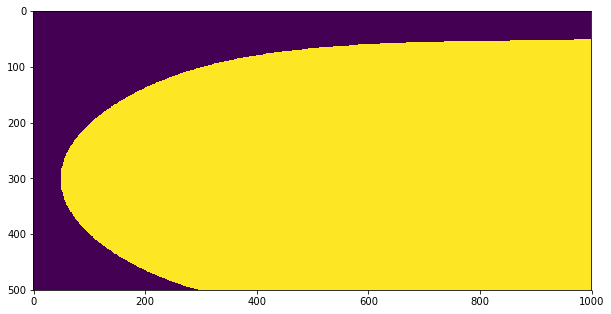

In [13]:
size, size_x = 500, 1000
empty_array = np.zeros(shape=(size, size_x))

x = np.linspace(0, size_x, 1000000)
y = (size - 250) *np.tanh(0.003 * x) ** 0.5

x2 = np.linspace(0, size_x, 1000000)
y2 = (-size + 250) *np.tanh(0.003 * x) ** 0.5

x = np.concatenate([x + 50, x2 + 50])
y = np.concatenate([y + 200, y2 + 200])

empty_array[-y.astype(int).clip(0, size - 1), 
             x.astype(int).clip(10, size_x - 1)] = 100


fig, ax = plt.subplots(figsize=(10, 10))
thresh_array = np.maximum.accumulate(empty_array.astype(int),1)
thresh_array = thresh_array==np.unique(thresh_array)[1]
thresh_array[0,:] = 0

# beach_curve = thresh_array
ax.imshow(thresh_array)


## Spectra

In [ ]:
# water_spectra = [255, 191, 101, 87, 52, 59]  # deep blue water (Stockton Beach)
# water_spectra = [709, 1028, 544, 226, 205, 180]  # shallow blue water (Stockton Beach)
water_spectra = [1952, 2113, 1110, 405, 340, 282]  # shallow/sandy bottom tropical water (GBR)
# water_spectra = [929, 1226, 1537, 1401, 248, 175]  # highly turbid water (cambridge gulf)
# water_spectra = [805, 1226, 1537, 777, 86, 68]  # mod turbid water (cambridge gulf)


# land_spectra = [2370, 3326, 4165, 4899, 6259, 5992]  # bright yellow sand, dry (Stockton Beach)
# land_spectra = [1084, 1677, 2155, 2544, 2679, 1889]  # bright yellow sand, wet (Stockton Beach)
# land_spectra = [604, 888, 1280, 1633, 1628, 1372]  # exposed cliff (Stockton Beach)
land_spectra = [670, 857, 910, 1107, 1463, 1048]  # tidal mudflat, dry (Darwin)
# land_spectra = [490, 639, 670, 756, 108, 69]  # tidal mudflat, wet (Darwin)
# land_spectra = [417, 528,  345, 2061, 712, 304]  # mangrove vegetation (Darwin)


water_spectra = [310, 262, 160, 125, 76, 60]  # deep water off Sydney
land_spectra = [1905, 2298, 2670, 3421, 3874, 3491]  # artificial (Sydney)


#                      'mangrove_vegetation': {'water': [766, 950, 752, 258, 148, 122], 
#                                              'land': [356, 459, 336, 1848, 598, 316]

# water_spectra = [310, 262, 486, 220, 76, 60]  
# land_spectra = [1905, 2298, 616, 3305, 3874, 3491] 

# water_spectra = [939,1330,1444,944,35,21]  # tidal mudflat 
# land_spectra = [733,965,1043,1088,220,126]  # tidal mudflat 


# water_spectra = [766, 950, 752, 258, 148, 122]
# land_spectra = [356, 459, 336, 1848, 598, 316]




# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.swir1) / (synthetic_ds.green + synthetic_ds.swir1)

plt.plot([490, 560, 670, 840, 1610, 2190], water_spectra, '-')
plt.plot([490, 560, 670, 840, 1610, 2190], land_spectra, '-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance x 10000');


In [ ]:
out_perc_land = []
out_ndwi = []
out_mndwi = []
out_awei_ns = []
out_awei_sh = []
out_wi = []

for perc_land in np.arange(0, 1.0, 0.01):
    
    mean_blue = np.mean(perc_land * land_spectra[0] + (1.0 - perc_land) * water_spectra[0])
    mean_green = np.mean(perc_land * land_spectra[1] + (1.0 - perc_land) * water_spectra[1])
    mean_red = np.mean(perc_land * land_spectra[2] + (1.0 - perc_land) * water_spectra[2])
    mean_nir = np.mean(perc_land * land_spectra[3] + (1.0 - perc_land) * water_spectra[3])
    mean_swir1 = np.mean(perc_land * land_spectra[4] + (1.0 - perc_land) * water_spectra[4])
    mean_swir2 = np.mean(perc_land * land_spectra[5] + (1.0 - perc_land) * water_spectra[5])        
    
    awei_ns = (4 * (mean_green * 0.0001 - mean_swir1 * 0.0001) - (0.25 * mean_nir * 0.0001 + 2.75 * mean_swir1 * 0.0001))
    awei_sh = mean_blue * 0.0001 + 2.5 * mean_green * 0.0001 - 1.5 * (mean_nir * 0.0001 + mean_swir1 * 0.0001) - 0.25 * mean_swir2 * 0.0001
    ndwi = (mean_green - mean_nir) / (mean_green + mean_nir)
    mndwi = (mean_green - mean_swir1) / (mean_green + mean_swir1)
    wi = (1.7204 + (171 * mean_green * 0.0001) + (3 * mean_red * 0.0001) - (70 * mean_nir * 0.0001) - (45 * mean_swir1 * 0.0001) - (71 * mean_swir2 * 0.0001))/15
    
    out_perc_land.append(perc_land) 
    out_ndwi.append(ndwi) 
    out_mndwi.append(mndwi)
    out_awei_ns.append(awei_ns)
    out_awei_sh.append(awei_sh)
    out_wi.append(wi)
    
out_indices = pd.DataFrame({'Fractional pixel composition (% land)': out_perc_land, 
                            'NDWI': out_ndwi, 
                            'MNDWI': out_mndwi, 
                            'AWEI_ns (Feyisa et al. 2014)': out_awei_ns, 
                            'AWEI_sh (Feyisa et al. 2014)': out_awei_sh, 
                            'WI (Fisher et al. 2016)': out_wi
                           })

fig, axes = plt.subplots(1, 2, figsize = (16, 8))
out_indices.plot(x='Fractional pixel composition (% land)', y = 'NDWI', ax=axes[0])
out_indices.plot(x='Fractional pixel composition (% land)', y = 'MNDWI', ax=axes[0])     
out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_ns (Feyisa et al. 2014)', ax=axes[1])     
out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_sh (Feyisa et al. 2014)', ax=axes[1])    
out_indices.plot(x='Fractional pixel composition (% land)', y = 'WI (Fisher et al. 2016)', ax=axes[1])  
axes[0].axvline(0.5, color='black', linestyle='--')
axes[1].axvline(0.5, color='black', linestyle='--')
axes[0].set_title('Non-linear')
axes[1].set_title('Linear')
axes[0].set_ylabel("Index value");


In [ ]:
# Create 3D array with water and land spectra
water_3d = np.broadcast_to(np.array(water_spectra), (size_x, size, 6)).T
land_3d = np.broadcast_to(np.array(land_spectra), (size_x, size, 6)).T
spectra_array = np.where(thresh_array, water_3d, land_3d)

# Add validation land, water distribution as extra band
spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

# Convert to xarray format and rename bands
synthetic_array = xr.DataArray(spectra_array, dims=['variable', 'y', 'x'], coords={'x': np.arange(0, 1000, 1),
                                                                                   'y': np.arange(0, -500, -1)})
synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                  4: 'nir', 5: 'swir1', 6: 'swir2'})


# Compute NDWI on validation dataset
# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.nir) / (synthetic_ds.green + synthetic_ds.nir)   
synthetic_ds['NDWI'] = (4 * (synthetic_ds.green * 0.0001 - synthetic_ds.swir1 * 0.0001) - (0.25 * synthetic_ds.nir * 0.0001 + 2.75 * synthetic_ds.swir1 * 0.0001))
synthetic_ds['land_water'] = synthetic_ds['NDWI'] > 0

# Set affine and CRS
synthetic_ds.attrs['transform'] = affine.Affine(1, 0, 0, 0, -1, 0)
synthetic_ds.attrs['crs'] = 'EPSG:4326'   

# Extract contours
val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = simulated_waterlines(synthetic_ds, 
                                                                                                         agg_factor = 30, 
                                                                                                         thresh_subpixel = -0.1,
                                                                                                         thresh_thresholded = -0.1,
                                                                                                         water_index='NDWI')

# Plot validation and aggregated landscapes
fig, ax = plt.subplots(1, 2, figsize=(20.25, 5))
synthetic_ds.NDWI.plot(ax=ax[0], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))
synthetic_coarse.NDWI.plot(ax=ax[1], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(22, 9))
synthetic_coarse.NDWI.plot(ax=ax, cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.90))
val_shoreline_gdf.plot(ax=ax, linewidth=3)
subpixel_shoreline_gdf.plot(ax=ax, color='red', linewidth=3)
blocky_shoreline_gdf.plot(ax=ax, color='black', linewidth=3)


## Analyse by threshold

In [685]:
index_scenarios = ['NDWI', 'MNDWI', 'AWEI_ns']  
thresh_subpixel_scenarios = np.round(np.arange(-1.5, 1.5, 0.01), 2)
resolution_scenarios = [4, 8, 14, 22, 30]

# Import spectra
output_spectra = pd.read_csv('spectra_outputs/output_spectra.csv', 
                             index_col='spectra').drop(['date', 'lat', 'lon'], axis=1)
output_spectra.index = output_spectra.index.str.split('_', expand=True)
spectra_scenarios = {level: output_spectra.xs(level).to_dict('index') for level in output_spectra.index.levels[0]}

# Create dataframe of all scenarios
all_combinations = itertools.product(spectra_scenarios, index_scenarios, 
                                     resolution_scenarios, thresh_subpixel_scenarios)
scenarios_df = pd.DataFrame(all_combinations, columns=['spectra', 'water_index', 
                                                       'resolution', 'thresh_subpixel'])

# Add new column duplicating subpixel threshold for threshholded analysis
scenarios_df['thresh_thresholded'] = scenarios_df.thresh_subpixel
scenarios_df.head(10)


,spectra,water_index,resolution,thresh_subpixel,thresh_thresholded
0,artificial,NDWI,4,-1.50,-1.50
1,artificial,NDWI,4,-1.49,-1.49
2,artificial,NDWI,4,-1.48,-1.48
3,artificial,NDWI,4,-1.47,-1.47
4,artificial,NDWI,4,-1.46,-1.46
5,artificial,NDWI,4,-1.45,-1.45
6,artificial,NDWI,4,-1.44,-1.44
7,artificial,NDWI,4,-1.43,-1.43
8,artificial,NDWI,4,-1.42,-1.42
9,artificial,NDWI,4,-1.41,-1.41


In [107]:
# Analyse scenarios   
accuracy_results = synthetic_scenarios(thresh_array, scenarios_df, spectra_scenarios, dist=5)   
accuracy_results.head()


Spectra: tidalflat Index: AWEI_ns Resolution: 30 Threshold subpixel: 1.49 Threshold threshholded: 1.49

,spectra,thresh,resolution,water_index,type,Error (m),otsu
0,artificial,-0.13,4,NDWI,Sub-pixel,2.000361,0.064659
1,artificial,-0.13,4,NDWI,Sub-pixel,3.084714,0.064659
2,artificial,-0.13,4,NDWI,Sub-pixel,3.676300,0.064659
3,artificial,-0.13,4,NDWI,Sub-pixel,2.026337,0.064659
4,artificial,-0.13,4,NDWI,Sub-pixel,3.769948,0.064659


In [682]:
# Fix names and formatting
accuracy_results['spectra'] = (accuracy_results['spectra']
                               .replace({'tidalflat': 'tidal\nmudflat',
                                         'artificial': 'artificial\nshoreline',
                                         'mangroveveg': 'mangrove\nvegetation',
                                         'rocky': 'rocky\nshoreline',
                                         'sandybeach': 'sandy\nbeach'}))

accuracy_results['water_index'] = (accuracy_results['water_index']
                               .replace({'AWEI_ns': 'AWEI$_{ns}$'}))

accuracy_results

,spectra,thresh,resolution,water_index,type,Error (m),otsu
0,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,2.000361,0.064659
1,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,3.084714,0.064659
2,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,3.676300,0.064659
3,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,2.026337,0.064659
4,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,3.769948,0.064659
5,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,2.726690,0.064659
6,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,2.731452,0.064659
7,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,4.066212,0.064659
8,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,2.431146,0.064659
9,artificial\nshoreline,-0.13,4,NDWI,Sub-pixel,3.749012,0.064659


In [683]:
accuracy_results.groupby('spectra')['Error (m)'].apply(RMSE)

spectra
artificial\nshoreline    8.530671
mangrove\nvegetation     7.776802
rocky\nshoreline         8.286275
sandy\nbeach             8.389681
tidal\nmudflat           7.771848
Name: Error (m), dtype: float64

### Plot results by threshold

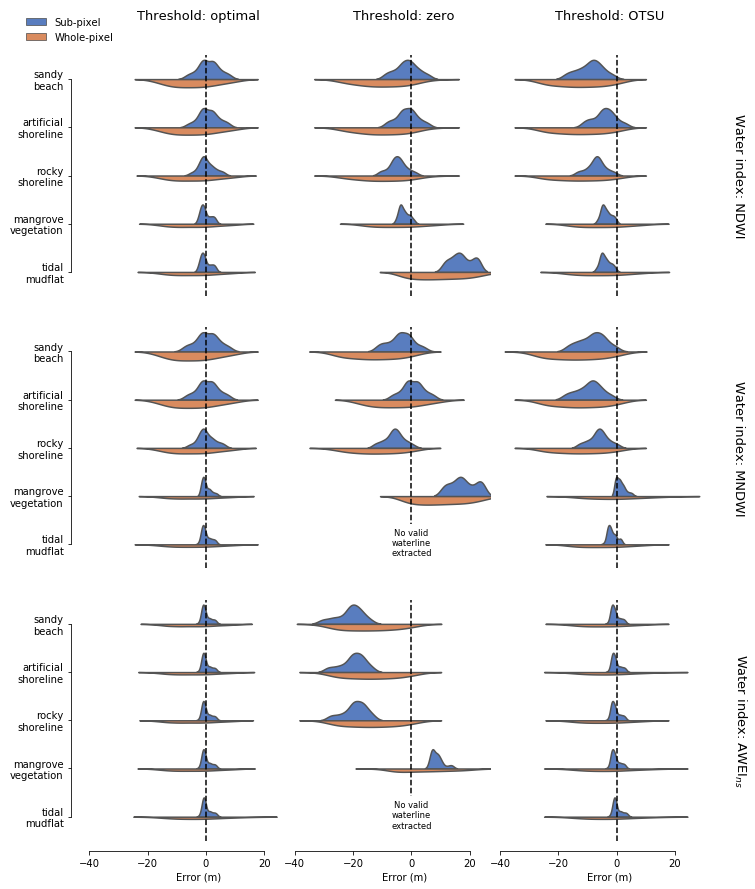

In [684]:
# Pull out only 30 resolution data
accuracy_spectra = accuracy_results[accuracy_results.resolution == 30].copy()

# Identify zero threshold
accuracy_spectra_zero = accuracy_spectra[np.round(accuracy_spectra.thresh, 2) == 0].copy()
accuracy_spectra_zero['thresh'] = 'zero\n'

# Identify closest threshold to OTSU for each set of scenarios
accuracy_spectra['diff_otsu'] = abs(accuracy_spectra.thresh - accuracy_spectra.otsu)
is_otsu = (accuracy_spectra
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['diff_otsu']
           .transform(min) == accuracy_spectra['diff_otsu'])
accuracy_spectra_otsu = accuracy_spectra[is_otsu].copy()
accuracy_spectra_otsu['thresh'] = 'OTSU\n'

# Identify optimal threshold
accuracy_spectra['RMSE'] = (accuracy_spectra
                            .groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)']
                            .transform(RMSE))   
is_optimal = (accuracy_spectra
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE']
           .transform(min) == accuracy_spectra['RMSE'])
accuracy_spectra_optimal = accuracy_spectra[is_optimal].copy()
accuracy_spectra_optimal['thresh'] = 'optimal\n'

# Merge all datasets into a single dataframe
accuracy_spectra_all = pd.concat([accuracy_spectra_optimal, 
                                  accuracy_spectra_zero, 
                                  accuracy_spectra_otsu], sort=False)


#################
# Generate plot #
#################

# Determine nice plotting order for spectra (from lowest to highest mean)
x_order = ['sandy\nbeach', 'artificial\nshoreline', 'rocky\nshoreline', 'mangrove\nvegetation', 'tidal\nmudflat']

g = sns.catplot(x="Error (m)", y="spectra", hue='type', data=accuracy_spectra_all, 
                col='thresh', row='water_index', height=4.0, aspect=0.9, palette="muted", 
                split=True, kind="violin", inner=None, scale='area', bw='silverman', 
                order=x_order, 
                orient='h',
                hue_order=['Sub-pixel', 'Whole-pixel'],
                col_order=['optimal\n', 'zero\n', 'OTSU\n'], 
                row_order=['NDWI', 'MNDWI', 'AWEI$_{ns}$'], 
                margin_titles=True, sharey=False, cut=1.7, gridsize=300)


# ##################
# # Customise plot #
# ##################

# Set up named axes
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)  = g.axes

# # Bulk add horizontal 0 error line to all plots
[ax.axvline(0, color='black', linestyle='--') for ax in g.axes.flat]

# Remove axis labels from bottom facets
ax1.set_ylabel('')
ax4.set_ylabel('')
ax7.set_ylabel('')

# Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = 'Water index: {row_name}', col_template = 'Threshold: {col_name}\n', size=13)

# Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)

# Remove axes lines and tickes from top facets
sns.despine(ax=ax1, bottom=True)
sns.despine(ax=ax2, left=True, bottom=True)
sns.despine(ax=ax3, left=True, bottom=True)
ax1.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)
ax3.tick_params(axis='both', which='both',length=0)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])

# Remove axes lines and tickes from middle facets
sns.despine(ax=ax4, bottom=True)
sns.despine(ax=ax5, left=True, bottom=True)
sns.despine(ax=ax6, left=True, bottom=True)
ax4.tick_params(axis='x', which='both',length=0)
ax5.tick_params(axis='both', which='both',length=0)
ax6.tick_params(axis='both', which='both',length=0)
ax5.set(yticklabels=[])
ax6.set(yticklabels=[])

# Remove axes lines and tickes from bottom facets
sns.despine(ax=ax8, left=True)
sns.despine(ax=ax9, left=True)
ax8.tick_params(axis='y', which='both',length=0)
ax9.tick_params(axis='y', which='both',length=0)
ax8.set(yticklabels=[])
ax9.set(yticklabels=[])

# # Add extra white space between columns
plt.subplots_adjust(hspace=0.13, wspace=-0.13)

# Make legend have two columns, and move to custom position
handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=1, loc='upper center', 
                bbox_to_anchor=(0.08, 1.02), frameon=False)

# Add annotation for missing MNDWI data
ax5.text(0, 4.45, "No valid\nwaterline\nextracted\n", horizontalalignment='center', size='small', 
         color='black', bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))
ax8.text(0, 4.45, "No valid\nwaterline\nextracted\n", horizontalalignment='center', size='small', 
         color='black', bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))

g.savefig('figures/paper/synthetic_snailplots.png', dpi=300)


## Analyse by resolution

In [743]:
# Copy into new resolution analysis dataset
accuracy_results_res = accuracy_results.copy()

# Identify and restrict to optimal threshold
accuracy_results_res['RMSE (m)'] = (accuracy_results
                                .groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)']
                                .transform(RMSE))   
is_optimal = (accuracy_results_res
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE (m)']
           .transform(min) == accuracy_results_res['RMSE (m)'])
accuracy_results_optimal = accuracy_results_res[is_optimal]

# Collapse into optimal RMSE at each distance
accuracy_results_res = (accuracy_results_optimal
                        .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE (m)', 'thresh']
                        .median()
                        .reset_index())


In [728]:
# accuracy_results_res.groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE (m)']

# accuracy_results

In [744]:
# (accuracy_results_optimal
#                         .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE (m)', 'thresh']
#                         .std()
#                         .reset_index())

### Plot results by resolution

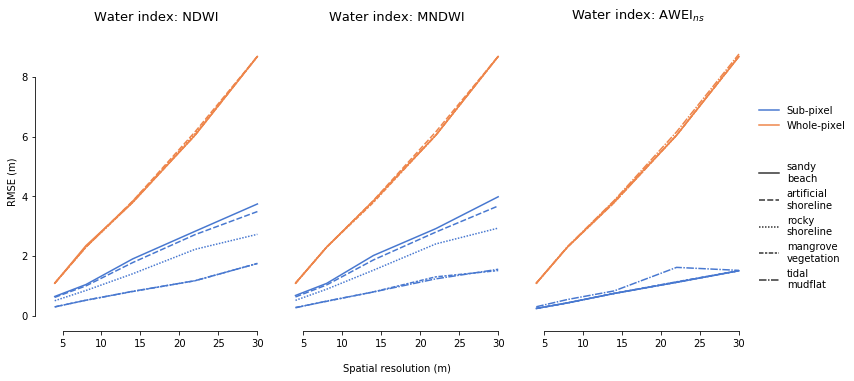

In [745]:
# Update AWEI name
accuracy_results_res = accuracy_results_res.rename({'resolution': '\nSpatial resolution (m)'}, axis=1)

# Plot data
g = sns.relplot(x="\nSpatial resolution (m)", 
                y="RMSE (m)", 
                hue='type', 
                col='water_index', 
                style='spectra',
                data=accuracy_results_res, 
                hue_order=['Sub-pixel', 'Whole-pixel'],
                col_order=['NDWI', 'MNDWI', 'AWEI$_{ns}$'],
                style_order = x_order, 
                height=5.0, 
                aspect=0.7, 
                palette="muted", 
                kind='line')

# Set up named axes
(ax1, ax2, ax3) = g.axes[0]

# Remove axis labels from bottom facets
ax1.set_xlabel('')
ax3.set_xlabel('')

# Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template = 'Water index: {col_name}\n', size=13)

# Remove legend titles
g._legend.texts[0].set_text("")
g._legend.texts[3].set_text("\n")
g._legend.set_title("")

# Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)
sns.despine(ax=ax2, left=True)
sns.despine(ax=ax3, left=True)
ax2.tick_params(axis='y', which='both', length=0)
ax3.tick_params(axis='y', which='both', length=0)

# Set axis limits
# g.set(yticks = [1, 3, 5, 7, 9])
# ax1.set_yticks([1, 9])

g.savefig('figures/paper/synthetic_resolution.png', dpi=300)


## Import WV2

In [2]:
import glob
import os
import pandas as pd
import xarray as xr
import affine
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

# Import study area
wv2_env_gdf = gpd.GeoDataFrame.from_file('raw_data/wv2_environments_buffer50.geojson')
wv2_env_gdf = wv2_env_gdf.to_crs({'init' :'EPSG:32755'})

# Get list of files to analysis
filenames = glob.glob('/g/data/u46/users/ia1511/Work/data/worldview-2/outdir/extracted/20300100B4EA4A00/RES-GROUP-0/STANDARDISED-PRODUCTS/REFLECTANCE/NBART/*.tif')

# Import data as a dask array with named bands based on file names
band = xr.Variable('band', [os.path.basename(f)[:-4].replace('-', '_') for f in filenames])
chunks = {'x': 5000, 'y': 5000, 'band': 1}
wv2_ds = xr.concat([xr.open_rasterio(f, chunks=chunks) for f in filenames], dim=band).to_dataset(dim='band')

# Fix nodata
wv2_ds = wv2_ds.where(wv2_ds != -999)

# Add affine
wv2_ds.attrs['transform'] = affine.Affine(*wv2_ds.transform)
wv2_ds.attrs['crs'] = wv2_ds.crs[6:]

# Create land-water array
wv2_ds['land_water'] = ((wv2_ds.BAND_G - wv2_ds.BAND_N)/(wv2_ds.BAND_G + wv2_ds.BAND_N)).compute() > 0
# wv2_ds['land_water'] = ((wv2_ds.BAND_C - wv2_ds.BAND_N2)/(wv2_ds.BAND_C + wv2_ds.BAND_N2)).compute() > 0


In [3]:
spectra_scenarios = ['mangrove_veg', 'rocky_cliff', 'sandy_beach'] 
index_scenarios = ['NDWI_wv2']  
resolution_scenarios = [2, 4, 7, 11, 15]
thresh_subpixel_scenarios = np.round(np.arange(-0.4, 0.2, 0.01), 2)

# Create dataframe of all scenarios
all_combinations = itertools.product(spectra_scenarios, index_scenarios, 
                                     resolution_scenarios, thresh_subpixel_scenarios)
scenarios_df = pd.DataFrame(all_combinations, columns=['spectra', 'water_index', 
                                                       'resolution', 'thresh_subpixel'])

# Add new column duplicating subpixel threshold for threshholded analysis
scenarios_df['thresh_thresholded'] = scenarios_df.thresh_subpixel
scenarios_df


,spectra,water_index,resolution,thresh_subpixel,thresh_thresholded
0,mangrove_veg,NDWI_wv2,2,-0.40,-0.40
1,mangrove_veg,NDWI_wv2,2,-0.39,-0.39
2,mangrove_veg,NDWI_wv2,2,-0.38,-0.38
3,mangrove_veg,NDWI_wv2,2,-0.37,-0.37
4,mangrove_veg,NDWI_wv2,2,-0.36,-0.36
5,mangrove_veg,NDWI_wv2,2,-0.35,-0.35
6,mangrove_veg,NDWI_wv2,2,-0.34,-0.34
7,mangrove_veg,NDWI_wv2,2,-0.33,-0.33
8,mangrove_veg,NDWI_wv2,2,-0.32,-0.32
9,mangrove_veg,NDWI_wv2,2,-0.31,-0.31


In [4]:
# Run simulation
accuracy_results_wv2 = wv2_scenarios(wv2_ds, scenarios_df, dist=5)

Spectra: mangrove_veg Index: NDWI_wv2 Aggregation: 2 Threshold subpixel: -0.4 Threshold threshholded: -0.4

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Spectra: sandy_beach Index: NDWI_wv2 Aggregation: 15 Threshold subpixel: 0.2 Threshold threshholded: 0.2

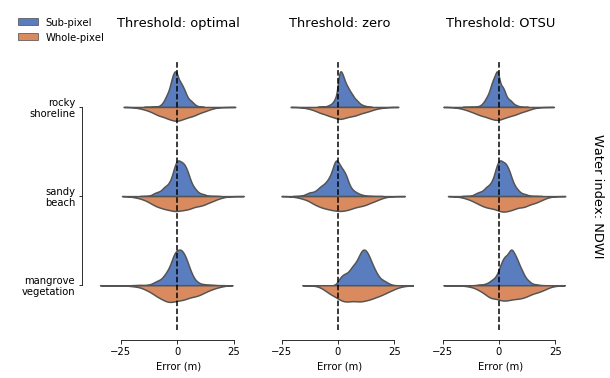

In [677]:
# Rename fields for plotting
accuracy_results_wv2['water_index'] = 'NDWI'
accuracy_results_wv2.loc[accuracy_results_wv2.spectra == 'mangrove_veg', 'spectra'] = 'mangrove_vegetation'
accuracy_results_wv2.loc[accuracy_results_wv2.spectra == 'bedrock\nshoreline', 'spectra'] = 'rocky_shoreline'
accuracy_results_wv2['spectra'] = accuracy_results_wv2.spectra.str.replace('_', '\n')

# Pull out only 30 resolution data
accuracy_wv2spectra = accuracy_results_wv2[accuracy_results_wv2.resolution == 15].copy()

# Identify zero threshold
accuracy_wv2spectra_zero = accuracy_wv2spectra[accuracy_wv2spectra.thresh == 0].copy()
accuracy_wv2spectra_zero['thresh'] = 'zero\n'

# Identify closest threshold to OTSU for each set of scenarios
accuracy_wv2spectra['diff_otsu'] = abs(accuracy_wv2spectra.thresh - accuracy_wv2spectra.otsu)
is_otsu = (accuracy_wv2spectra
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['diff_otsu']
           .transform(min) == accuracy_wv2spectra['diff_otsu'])
accuracy_wv2spectra_otsu = accuracy_wv2spectra[is_otsu].copy()
accuracy_wv2spectra_otsu['thresh'] = 'OTSU\n'

# Identify optimal threshold
accuracy_wv2spectra['RMSE'] = (accuracy_wv2spectra
                                .groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)']
                                .transform(RMSE))   
is_optimal = (accuracy_wv2spectra
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE']
           .transform(min) == accuracy_wv2spectra['RMSE'])
accuracy_wv2spectra_optimal = accuracy_wv2spectra[is_optimal].copy()
accuracy_wv2spectra_optimal['thresh'] = 'optimal\n'


# Merge all datasets into a single dataframe
accuracy_wv2spectra_all = pd.concat([accuracy_wv2spectra_optimal, 
                                     accuracy_wv2spectra_zero, 
                                     accuracy_wv2spectra_otsu], sort=False)


#################
# Generate plot #
#################

# Determine nice plotting order for spectra (from lowest to highest mean)
x_order = ['rocky\nshoreline', 'sandy\nbeach', 'mangrove\nvegetation']

g = sns.catplot(x="Error (m)", y="spectra", hue='type', 
                data=accuracy_wv2spectra_all, 
                col='thresh', row='water_index', height=4.8, aspect=0.6, palette="muted", 
                split=True, kind="violin", inner=None, scale='area', bw='silverman', 
                order=x_order, 
                orient='h',
                hue_order=['Sub-pixel', 'Whole-pixel'],
                col_order=['optimal\n', 'zero\n', 'OTSU\n'], 
                margin_titles=True, sharey=False, cut=1.5, gridsize=300)


##################
# Customise plot #
##################

# # # Set up named axes
ax1, ax2, ax3  = g.axes.flat

# # # Bulk add horizontal 0 error line to all plots
[ax.axvline(0, color='black', linestyle='--') for ax in g.axes.flat]

# # # Remove axis labels from bottom facets
ax1.set_ylabel('')

# # # Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = 'Water index: {row_name}', col_template = 'Threshold: {col_name}\n', size=13)

# # # Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)

# Remove axes lines and tickes from top facets
sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True)
sns.despine(ax=ax3, left=True)
ax2.tick_params(axis='y', which='both',length=0)
ax3.tick_params(axis='y', which='both',length=0)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])

# # # Add extra white space between columns
plt.subplots_adjust(hspace=0.13, wspace=-0.07)

# Make legend have two columns, and move to custom position
handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=1, loc='upper center', 
                bbox_to_anchor=(0.085, 1.07), frameon=False)

g.savefig('figures/paper/wv2_spectra.png', dpi=300)

## Analyse by resolution

In [678]:
# Copy into new resolution analysis dataset
accuracy_wv2res = accuracy_results_wv2.copy()

# Identify and restrict to optimal threshold
accuracy_wv2res['RMSE (m)'] = (accuracy_wv2res
                                .groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)']
                                .transform(RMSE))   
is_optimal = (accuracy_wv2res
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE (m)']
           .transform(min) == accuracy_wv2res['RMSE (m)'])
accuracy_wv2res = accuracy_wv2res[is_optimal]

# Collapse into optimal RMSE at each distance
accuracy_wv2res = (accuracy_wv2res
                        .groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['RMSE (m)']
                        .first()
                        .reset_index())

# Update resolution
accuracy_wv2res['resolution'] = accuracy_wv2res['resolution'] * 2
accuracy_wv2res = accuracy_wv2res.rename({'resolution': '\nSpatial resolution (m)'}, axis=1)
accuracy_wv2res.head()

,spectra,thresh,Spatial resolution (m),water_index,type,RMSE (m)
0,mangrove\nvegetation,-0.37,30,NDWI,Whole-pixel,8.383818
1,mangrove\nvegetation,-0.30,30,NDWI,Sub-pixel,4.519067
2,mangrove\nvegetation,-0.27,22,NDWI,Sub-pixel,3.309542
3,mangrove\nvegetation,-0.27,22,NDWI,Whole-pixel,6.528927
4,mangrove\nvegetation,-0.23,14,NDWI,Sub-pixel,2.098687


### Plot results by resolution

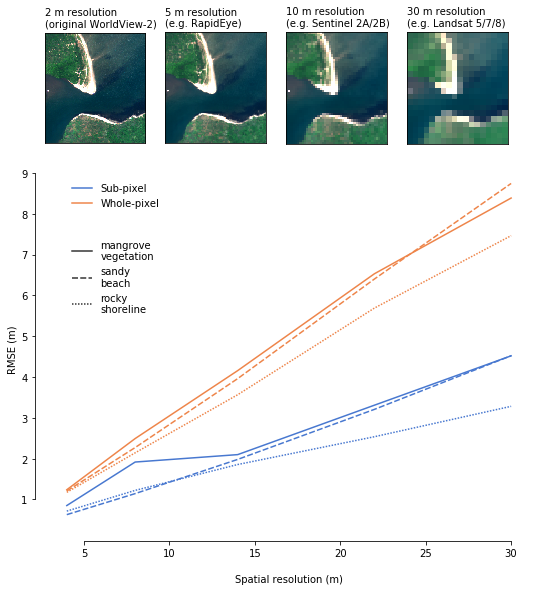

In [679]:
# Plot data
g = sns.relplot(x="\nSpatial resolution (m)", 
                y="RMSE (m)", 
                hue='type', 
                style='spectra',
                data=accuracy_wv2res, 
                hue_order=['Sub-pixel', 'Whole-pixel'],
                style_order = ['mangrove\nvegetation', 'sandy\nbeach', 'rocky\nshoreline'], 
                height=6.0, 
                aspect=1.25, 
                palette="muted", 
                kind='line')

# Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template = 'Water index: {col_name}\n', size=13)

# Remove legend titles
g._legend.texts[0].set_text("")
g._legend.texts[3].set_text("\n")
g._legend.set_title("")
g._legend.set_bbox_to_anchor([0.1, 1.0])  
g._legend._loc = 2

# Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)

# Add in insets at top of plot
gs2 = matplotlib.gridspec.GridSpec(1,4, bottom=1.0, top=1.30, right=0.80)
ax1 = g.fig.add_subplot(gs2[0])
ax2 = g.fig.add_subplot(gs2[1])
ax3 = g.fig.add_subplot(gs2[2])
ax4 = g.fig.add_subplot(gs2[3])
thumbnail_axes = [ax1, ax2, ax3, ax4]


titles = ['2 m resolution\n(original WorldView-2)',
          '5 m resolution\n(e.g. RapidEye)',
          '10 m resolution\n(e.g. Sentinel 2A/2B)',
          '30 m resolution\n(e.g. Landsat 5/7/8)']

for i, agg in enumerate([1, 3, 6, 15]):

    rgb_array = np.transpose(wv2_ds[['BAND_R', 'BAND_G', 'BAND_B']]
                             .sel(y=slice(8239400, 8238800), 
                                  x=slice(324525, 325075))
                             .to_array()
                             .coarsen(x=agg, y=agg, boundary='trim')
                             .mean()
                             .values, axes=[1, 2, 0]) / 10000.0
    
    p_low, p_high = np.percentile(rgb_array, q=[3, 97])
    rescaled_array = exposure.rescale_intensity(rgb_array, 
                               in_range=(p_low, p_high),
                               out_range='dtype')
    
    thumbnail_axes[i].imshow(rescaled_array)
    thumbnail_axes[i].set_title(titles[i], loc="left", fontsize=10)
    thumbnail_axes[i].get_xaxis().set_visible(False)
    thumbnail_axes[i].get_yaxis().set_visible(False)

g.savefig('figures/paper/wv2_resolution.png', dpi=300)


In [988]:
# Pull out only 30m resolution scenarios
optimal_thresh_df = (accuracy_wv2res.loc[accuracy_wv2res.iloc[:,2] == 30, ['spectra', 'type', 'thresh']]
                    .set_index(['spectra', 'type']))

# Transform into a nested dictionary
optimal_thresh_dict = {level.replace('\n', '_'): optimal_thresh_df.xs(level).iloc[:,0].to_dict() for 
                       level in optimal_thresh_df.index.levels[0]}

# Create a dict that maps each environment to a region for plotting
study_area_dict = {'mangrove_vegetation': {'y': 8238920, 'x': 324450},                  
                   'sandy_beach': {'y': 8232389, 'x': 331730},
                   'rocky_shoreline': {'y': 8236763, 'x': 329300}}  

# Create a dict that maps each environment to a unique subplot title
env_ann = {'mangrove_vegetation': 'a)  Mangrove vegetation',
           'sandy_beach': 'b)  Sandy beach', 
           'rocky_shoreline': 'c)  Rocky shoreline'}


mangrove_vegetation {'Whole-pixel': -0.37, 'Sub-pixel': -0.3}
rocky_shoreline {'Sub-pixel': -0.08, 'Whole-pixel': -0.06}
sandy_beach {'Whole-pixel': -0.01, 'Sub-pixel': 0.03}


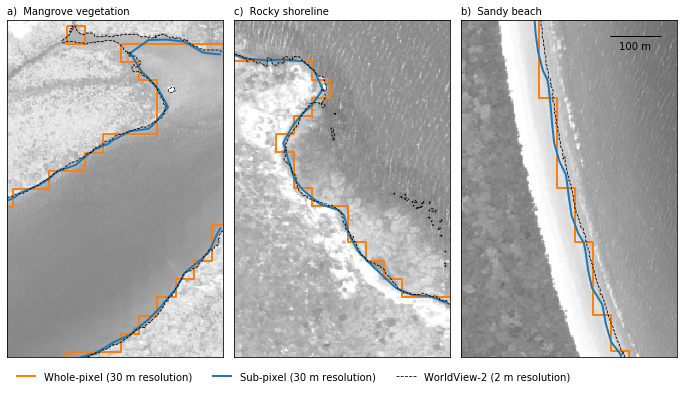

In [947]:
# Create a 1 by 3 subplot figure
fig, axes = plt.subplots(1, 3, figsize=(12, 8))

for i, (spectra, val_dict) in enumerate(optimal_thresh_dict.items()):
    
    print(spectra, val_dict)
    
    # Generate study area by buffering around points in `study_area_dict`
    buffer_x, buffer_y = 200, 300
    ymin = study_area_dict[spectra]['y'] - buffer_y
    ymax = study_area_dict[spectra]['y'] + buffer_y
    xmin = study_area_dict[spectra]['x'] - buffer_x
    xmax = study_area_dict[spectra]['x'] + buffer_x   
    
    # Subset to corresponding region out of full WV-2 dataset, and update transform
    subset_ds = wv2_ds.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))
    subset_ds.attrs['transform'] = Affine(2.0, 0.0, xmin, 0.0, -2.0, ymax)
    
    # Extract waterlines based on subsetted dataset and thresholds
    ref_gdf, subpixel_gdf, wholepixel_gdf, ds_agg = simulated_waterlines(subset_ds, 
                                                                         agg_factor = 15, 
                                                                         thresh_subpixel = val_dict['Sub-pixel'], 
                                                                         thresh_thresholded = val_dict['Whole-pixel'], 
                                                                         water_index='NDWI_wv2', 
                                                                         min_vertices=1,
                                                                         outdir=f'output_data/wv2/examples/{spectra}_')
    
    # Convert subsetted dataset to a RGB numpy array with values between 0-1.0
    rgb_array = np.transpose(subset_ds[['BAND_R', 'BAND_G', 'BAND_B']]
                             .to_array()
                             .values, axes=[1, 2, 0]) / 10000.0
    
    # Optimise colour stretch using a percentile clip
    p_low, p_high = np.percentile(rgb_array, q=[3, 97])
    rescaled_array = exposure.rescale_intensity(rgb_array, 
                                                in_range=(p_low, p_high),
                                                out_range='dtype')
    
    # Compute x and y mins and maxes so that plt.imshow can plot our data with geographic
    # coordinates. Because whole-pixel shorelines include extraneous polygon boundaries that
    # we will remove below, we need to reduce the extents by 20m (10 pixels) in every direction
    study_area_buffer = (subset_ds.x.min().item() + 20, subset_ds.x.max().item() - 20, 
                         subset_ds.y.min().item() + 20, subset_ds.y.max().item() - 20)

    # Plot the RGB array after reducing its extents by 10 pixels (20m) in each direction
    axes[i].imshow(rgb2gray(rescaled_array)[10:-10, 10:-10], 
                   cmap='Greys_r', 
                   vmin=0, vmax=1.0, 
                   extent=study_area_buffer, 
                   alpha=0.7)

    # To make sure all features plot together nicely and do not extend over the plot boundaries, 
    # we clip everything to the 20m reduced extent study area above, then add them all to the plot
    study_area_poly = box(*[study_area_buffer[i] for i in [0, 2, 1, 3]]) 
    wholepixel_gdf.intersection(study_area_poly).plot(ax=axes[i], 
                                                      color='#ff7f0e', 
                                                      linewidth=2, 
                                                      label='Whole-pixel (30 m resolution)')
    subpixel_gdf.intersection(study_area_poly).plot(ax=axes[i], 
                                                    color='#1f77b4', 
                                                    linewidth=2, 
                                                    label='Sub-pixel (30 m resolution)')
    ref_gdf.intersection(study_area_poly).plot(ax=axes[i], 
                                               color='black', 
                                               linestyle='--', 
                                               linewidth=0.8, 
                                               label='WorldView-2 (2 m resolution)')
    
    # Set axis titles using the `env_ann` lookup table, and hide all axes
    axes[i].set_title(env_ann[spectra], loc="left", fontsize=10)
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

# Add a scalebare. This doesn't appear to plot the true geographic distance, so we
# use a value of 85 as a hack to force it to the correct 100m length
scalebar = AnchoredSizeBar(axes[2].transData,
                           85, '100 m', 'upper right', 
                           pad=1.5, sep=5,
                           frameon=False,
                           size_vertical=0)
axes[2].add_artist(scalebar)
    
# Remove extra space
plt.subplots_adjust(wspace=0.05)

# Add legend below plot
axes[0].legend(loc='lower left', 
               bbox_to_anchor=(0, -0.10), 
               fancybox=False, 
               shadow=False, 
               ncol=3, 
               frameon=False)

# Save plot to file
fig.savefig('figures/paper/wv2_examples.png', dpi=300, bbox_inches='tight')
    

## Synthetic example plot

In [983]:
# Pull out only 30m scenarios and sandy beach/tidal mudflat environments
optimal_thresh_df = (accuracy_results_res.loc[(accuracy_results_res.iloc[:,1] == 30) &
                                              accuracy_results_res.spectra.isin(['sandy\nbeach', 'tidal\nmudflat']), 
                                              ['spectra', 'type', 'thresh', 'water_index']]
                     .set_index(['spectra', 'type', 'water_index']))

# Create column giving the matplotlib axis/subplot in which to plot each dataset
optimal_thresh_df['ax'] = [4, 4, 2, 2, 0, 0, 5, 5, 3, 3, 1, 1]

# Rename values in the dataframe and sort before plotting
optimal_thresh_df = optimal_thresh_df.sort_index(level=[0, 1], ascending=False)
optimal_thresh_df


thresh  ax
spectra        type        water_index            
tidal\nmudflat Whole-pixel NDWI           0.20   1
                           MNDWI          0.75   3
                           AWEI$_{ns}$    0.22   5
               Sub-pixel   NDWI           0.23   1
                           MNDWI          0.75   3
                           AWEI$_{ns}$    0.22   5
sandy\nbeach   Whole-pixel NDWI          -0.14   0
                           MNDWI         -0.23   2
                           AWEI$_{ns}$   -1.25   4
               Sub-pixel   NDWI          -0.05   0
                           MNDWI         -0.11   2
                           AWEI$_{ns}$   -1.35   4

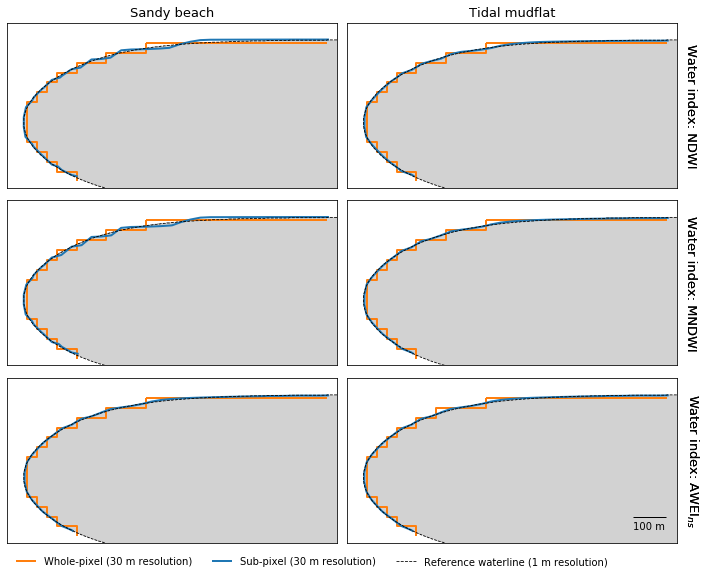

In [986]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9.7))

for i, (spectra, waterline_type, water_index, thresh, ax) in optimal_thresh_df.reset_index().iterrows():
    
    # Generate synthetic xarray dataset for given environment's spectra   
    ds = synthetic_spectra(thresh_array=thresh_array, 
                           spectra_scenarios=spectra_scenarios, 
                           spectra={'sandy\nbeach': 'sandybeach', 
                                    'tidal\nmudflat': 'tidalflat'}[spectra])    
    
    # Extract waterlines for given environment and thresholds
    ref_gdf, subpixel_gdf, wholepixel_gdf, ds_agg = simulated_waterlines(ds, 
                                                                         agg_factor = 30, 
                                                                         thresh_subpixel = thresh, 
                                                                         thresh_thresholded = thresh, 
                                                                         water_index=water_index.replace('$_{ns}$', '_ns'), 
                                                                         min_vertices=1,
                                                                         outdir=f'output_data/synthetic/examples/{spectra}_')
    
    # Depending on the scenario, add reference, subpixel and whole pixel waterlines to plot
    if waterline_type == 'Whole-pixel':
        
        # Plot background array based on reference land/water distribution
        axes.flat[ax].imshow(ds.land_water.values, cmap='Greys_r', alpha=0.18)
        
        # Add whole pixel waterline after clipping inwards to remove bottom and right polygon bounds
        wholepixel_clipped = gdfwholepixel_gdf.intersection(box(0, 0, 970, 479))
        wholepixel_clipped.plot(ax=axes.flat[ax], 
                                color='#ff7f0e', 
                                linewidth=2, 
                                label='Whole-pixel (30 m resolution)')  
        
    else:
        
        # Add subpixel waterline
        subpixel_gdf.plot(ax=axes.flat[ax], 
                          color='#1f77b4',
                          linewidth=2, 
                          label='Sub-pixel (30 m resolution)')
        
        # Add reference waterline
        ref_gdf.plot(ax=axes.flat[ax], 
                     color='black', 
                     linestyle='--', 
                     linewidth=0.8, 
                     label='Reference waterline (1 m resolution)')
        
    # If one of the top two subplots, add environment names
    if ax in [0, 1]:
        axes.flat[ax].set_title(spectra.replace('\n', ' ').capitalize(), 
                                loc='center', 
                                size=13)
        
    # If one of the three right subplots, add water index names    
    if ax in [1, 3, 5]:
        axes.flat[ax].text(1020, 250, 
                           f'Water index: {water_index}', 
                           size=13,
                           verticalalignment='center', 
                           rotation=270)
        
    # Hide axis labels
    axes.flat[ax].get_xaxis().set_visible(False)
    axes.flat[ax].get_yaxis().set_visible(False)

# Add in a scale bar   
scalebar = AnchoredSizeBar(transform=axes.flat[5].transData,
                           size=100, 
                           label='100 m', 
                           loc='lower right', 
                           pad=1, 
                           sep=5,
                           frameon=False,
                           size_vertical=0)
axes.flat[5].add_artist(scalebar)

# Remove extra space
plt.subplots_adjust(wspace=0.03, hspace=0.03)

# Add legend under the plot
axes.flat[4].legend(loc='lower left', 
                    bbox_to_anchor=(0, -0.2), 
                    fancybox=False, 
                    shadow=False, 
                    ncol=3, 
                    frameon=False)

# Save to file
fig.savefig('figures/paper/spectra_examples.png', dpi=300, bbox_inches='tight')
    